# Program ML Sistem Rekomendasi Akomodasi dengan Content Based Filtering

## Library yang digunakan

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import Huber
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Upload Dataset

In [ ]:
# Load dataset
file_path = 'Akomodasi.xlsx'
df = pd.read_excel(file_path, sheet_name='Sheet1')
df.head()

,Name,Original Price,price_after_discount,tax,Rating,Kota/Kabupaten
0,The Anvaya Beach Resort Bali,5022000,4017600,Inclusive of taxes,4.45,Badung
1,The Apurva Kempinski Bali,14520640,10890480,Inclusive of taxes,4.45,Badung
2,The Sakala Resort Bali - All Suites,2400000,1392000,Inclusive of taxes,4.25,Badung
3,Discovery Kartika Plaza Bali,1733333,1300000,Inclusive of taxes,4.30,Badung
4,Hilton Bali Resort,3872000,2904000,Inclusive of taxes,4.35,Badung


In [ ]:
# Pilih kolom yang digunakan
selected_columns = {
    "Name": "name",
    "Rating": "rating",
    "Original Price": "price_wna", # Harga yang digunakan hanya harga WNA dewasa
    "Kota/Kabupaten": "city",
}
# Rename kolom
df = df.rename(columns=selected_columns)
# Pilih kolom yang telah direname
df = df[['name', 'rating', 'price_wna', 'city']]
# Bersihkan data kosong dan sesuaikan tipe data
data = df.dropna(subset=["name", "rating", "price_wna", "city"])
data["price_wna"] = data["price_wna"].astype(float)
data["rating"] = data["rating"].astype(float)

## Normalisasi dan encoding 4 fitur yang digunakan

In [ ]:
# Normalisasi price and rating
scaler = MinMaxScaler()
data[['price_wna', 'rating']] = scaler.fit_transform(data[['price_wna', 'rating']])

# One-hot encode untuk category and city
encoder_city = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

encoded_city = encoder_city.fit_transform(data[['city']])

# Gabungkan 4 fitur yang dipilih
X = np.hstack(( encoded_city, data[['price_wna', 'rating']].values))

# Dummy target untuk pelatihan
y = np.random.rand(len(X))

## Model neural network

In [ ]:
# Split dataset 80% test 20% validation
train_X, test_X, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Augment data by adding noise (for training set)
train_X_noisy = train_X + np.random.normal(0, 0.01, train_X.shape)
# Bangun model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(train_X.shape[1],)),
    tf.keras.layers.Dense(12, activation='relu', kernel_regularizer=l2(0.001)),  # Simplified
    tf.keras.layers.Dropout(0.1),  # Lower dropout
    tf.keras.layers.Dense(6, activation='relu', kernel_regularizer=l2(0.001)),  # Reduced neurons
    tf.keras.layers.Dense(1, activation='sigmoid')  # Sigmoid for binary output
])

# Definisikan metric RMSE
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

# Compile model
huber_loss = Huber(delta=1.0)
model.compile(optimizer=Adam(learning_rate=0.0005), loss=huber_loss, metrics=['mae', rmse])

# Callbacks: Early Stopping and Learning Rate Scheduler
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Reduced patience
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,  # More aggressive reduction
    patience=2,
    min_lr=1e-6
)

# Train model
history = model.fit(
    train_X_noisy, y_train,  # Use augmented data for training
    validation_split=0.2,  # Use 20% of training data for validation
    epochs=100,  # Start with more epochs and rely on early stopping
    batch_size=4,  # Smaller batch size for better performance with small data
    shuffle=True,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0643 - mae: 0.2666 - rmse: 0.2927 - val_loss: 0.0587 - val_mae: 0.2524 - val_rmse: 0.2790 - learning_rate: 5.0000e-04
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0632 - mae: 0.2678 - rmse: 0.2984 - val_loss: 0.0561 - val_mae: 0.2512 - val_rmse: 0.2780 - learning_rate: 5.0000e-04
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0593 - mae: 0.2597 - rmse: 0.2909 - val_loss: 0.0538 - val_mae: 0.2503 - val_rmse: 0.2773 - learning_rate: 5.0000e-04
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0534 - mae: 0.2447 - rmse: 0.2769 - val_loss: 0.0521 - val_mae: 0.2499 - val_rmse: 0.2774 - learning_rate: 5.0000e-04
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0543 - mae: 0.2545 - rmse: 0.2836 - val_loss: 0.0505 - val_mae: 0.2492 - val_rmse: 0.2770 - learning_rate: 5.0000e-04
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0537 - mae: 0.2570 - rmse: 0.2865 - val_loss

In [ ]:
# Display summary model
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                     │ (None, 12)                  │             132 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 12)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 6)                   │              78 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 653 (2.55 KB)

 Trainable params: 217 (868.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 436 (1.71 KB)

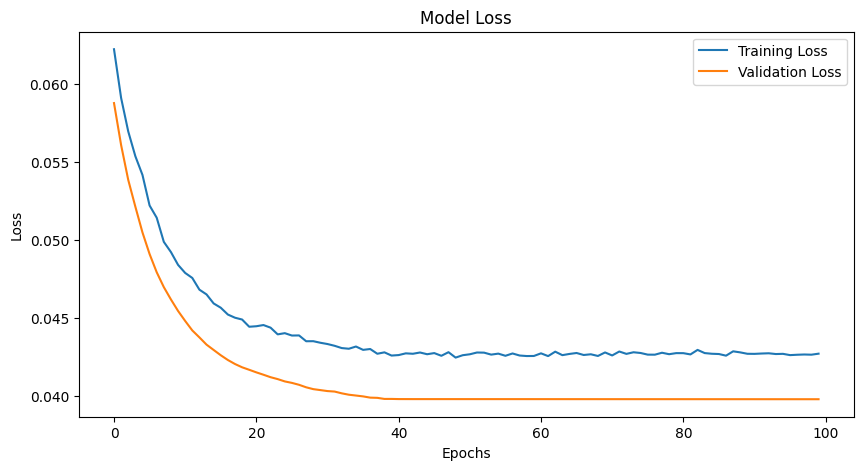

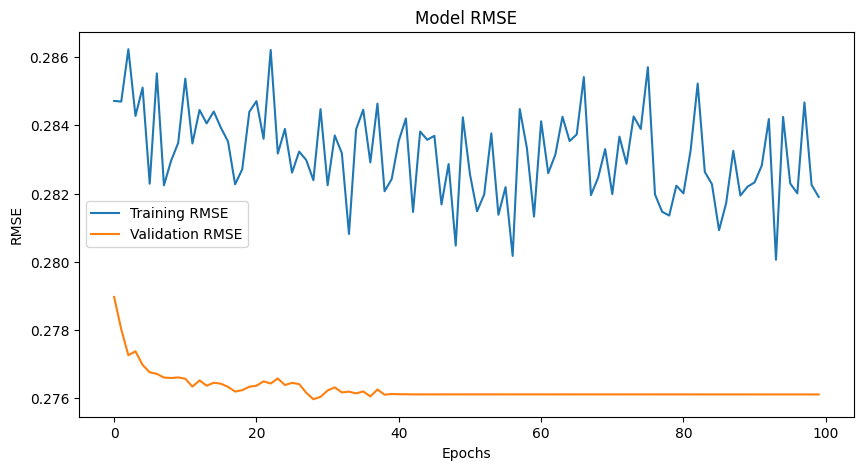

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation RMSE
plt.figure(figsize=(10, 5))
plt.plot(history.history['rmse'], label='Training RMSE')
plt.plot(history.history['val_rmse'], label='Validation RMSE')
plt.title('Model RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

## Fungsi untuk preproses input dan menampilkan output rekomendasi berdasarkan filter

In [ ]:
# fungsi untuk mengolah input agar format sesuai dengan model
def preprocess_user_input(user_input):
    # Buat DataFrame dari input pengguna
    user_df = pd.DataFrame([{
        "price_wna": user_input["max_price"],
        "rating": user_input["min_rating"]
    }])

    # Normalisasi input pengguna menggunakan scaler
    normalized_input = scaler.transform(user_df)

    # Encode kategori dan kota
    user_city = encoder_city.transform([[user_input['city']]])

    # Gabungkan semua fitur
    user_vector = np.hstack((user_city, normalized_input))

    return user_vector


In [ ]:
# Fungsi untuk menampilkan top 5 rekomendasi berdasarkan input user
def recommend(user_input, top_n=5):
    # Preproses input pengguna
    user_input_vector = preprocess_user_input(user_input)

    # Prediksi score untuk masing-masing data
    scores = model.predict(X)
    data['score'] = scores.flatten()

    # Normalisasi nilai filter dari input pengguna
    user_df = pd.DataFrame([{
        "price_wna": user_input["max_price"],
        "rating": user_input["min_rating"]
    }])
    normalized_input = scaler.transform(user_df)
    max_price_scaled, min_rating_scaled = normalized_input[0]

    # Filter data berdasarkan kriteria pengguna
    filtered_data = data[
        (data['rating'] >= min_rating_scaled) &
        (data['price_wna'] <= max_price_scaled) &
        (data['city'] == user_input['city'])  # Filter berdasarkan kota
    ]

    # Kembalikan nilai rating dan price_wna ke skala asli
    if not filtered_data.empty:
        filtered_data[['price_wna', 'rating']] = scaler.inverse_transform(
            filtered_data[['price_wna', 'rating']]
        )

    # Ambil rekomendasi top-N
    if not filtered_data.empty:
        recommendations = filtered_data.nlargest(top_n, 'score')
    else:
        print("No recommendations found based on the given criteria.")
        recommendations = pd.DataFrame()  # DataFrame kosong jika tidak ada rekomendasi

    # Pilih kolom yang relevan untuk output
    selected_columns = ['name', 'rating', 'price_wna', 'city']
    available_columns = recommendations.columns.tolist()
    selected_columns = [col for col in selected_columns if col in available_columns]

    return recommendations[selected_columns]


## Penggunaan input untuk rekomendasi berdasarkan filter

In [ ]:
# Input dari pengguna
user_input = {
    "city": input("Enter the city you want to go to : "),            # Contoh: "Denpasar"
    "min_rating": float(input("Enter the minimum rating (0.0-5.0): ")),  # Contoh: 4.0
    "max_price": float(input("Enter the maximum ticket price (IDR) : "))  # Contoh: 50000
}

# Tampilkan rekomendasi
top_5_recommendations1 = recommend(user_input)
print(top_5_recommendations1)

Enter the city you want to go to : Badung
Enter the minimum rating (0.0-5.0): 4
Enter the maximum ticket price (IDR) : 40000000
 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
                                  name  rating  price_wna    city
0         The Anvaya Beach Resort Bali    4.45  5022000.0  Badung
2  The Sakala Resort Bali - All Suites    4.25  2400000.0  Badung
3         Discovery Kartika Plaza Bali    4.30  1733333.0  Badung
4                   Hilton Bali Resort    4.35  3872000.0  Badung
5                       The ONE Legian    4.25  1440000.0  Badung


<ipython-input-9-fea5fca2349f>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[['price_wna', 'rating']] = scaler.inverse_transform(


## Fungsi untuk rekomendasi berdasarkan Akomodasi yang sebelumnya dikunjungi

In [ ]:
# fungsi untuk rekomendasi berdasarkan Akomodasi yang telah dikunjungi
def recommend_similar_Akomodasi(Akomodasi_name, city_filter=None, max_price=None, top_n=5):
    # Pastikan nama Akomodasi ada dalam data
    if Akomodasi_name not in data['name'].values:
        print(f"Akomodasi '{Akomodasi_name}' tidak ditemukan dalam data.")
        return pd.DataFrame()

    # Pilih fitur yang digunakan untuk perhitungan similarity
    features = np.hstack((
        encoded_city,
        data[['price_wna', 'rating']].values
    ))

    # Ambil indeks Akomodasi yang diminta
    Akomodasi_idx = data[data['name'] == Akomodasi_name].index[0]

    # Hitung kesamaan menggunakan cosine similarity antara Akomodasi input dengan semua Akomodasi lainnya
    similarity_scores = cosine_similarity(features[Akomodasi_idx].reshape(1, -1), features).flatten()

    # Tambahkan skor kesamaan ke dalam DataFrame
    data['similarity'] = similarity_scores

    # Ubah tipe data max_price ke float jika tidak kosong
    if max_price is not None:
        max_price = float(max_price)

    # Filter data jika ada city_filter atau max_price
    filtered_data = data[data['name'] != Akomodasi_name]
    if city_filter:
        filtered_data = filtered_data[filtered_data['city'] == city_filter]
    if max_price is not None:
        # Normalisasi max_price untuk filter
        max_price_scaled = scaler.transform([[max_price, 0]])[0][0]
        filtered_data = filtered_data[filtered_data['price_wna'] <= max_price_scaled]

    # Kembalikan nilai rating dan price_wna ke skala aslinya
    if not filtered_data.empty:
        filtered_data.loc[:, ['price_wna', 'rating']] = scaler.inverse_transform(
            filtered_data[['price_wna', 'rating']]
        )

    # Urutkan berdasarkan skor similarity (descending) dan ambil top-N
    recommendations = filtered_data.nlargest(top_n, 'similarity') if not filtered_data.empty else pd.DataFrame()

    # Pilih kolom untuk ditampilkan
    return recommendations[['name', 'rating', 'price_wna', 'city', 'similarity']]


## Penggunaan input rekomendasi berdasarkan Akomodasi yang sebelumnya dikunjungi

In [ ]:
# input dari user
Akomodasi_name = input("Enter the name of destination you have already visited : ")
city_filter = input("Enter the city you want to go to (optional): ") or None
max_price = input("Enter the maximum ticket price (optional): ") or None

# output
top_5_recommendations = recommend_similar_Akomodasi(Akomodasi_name, city_filter=city_filter, max_price=max_price)
print(top_5_recommendations)

Enter the name of destination you have already visited : The Anvaya Beach Resort Bali
Enter the city you want to go to (optional): Badung
Enter the maximum ticket price (optional): 50000000000
                                    name  rating  price_wna    city  \
166  InterContinental Hotels BALI RESORT    4.45  5145998.0  Badung   
43      Hotel Indigo BALI SEMINYAK BEACH    4.50  5096637.0  Badung   
336               The Wolas Villas & Spa    4.40  4971285.0  Badung   
76               Buana Bali Villas & Spa    4.45  5580000.0  Badung   
286           The Seiryu Boutique Villas    4.40  4636979.0  Badung   

     similarity  
166    0.999993  
43     0.999895  
336    0.999889  
76     0.999851  
286    0.999837  


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
